In [1]:
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from msmbuilder.decomposition import tICA, PCA

In [3]:
dataFull = np.loadtxt('ala4_explicit/COLVAR_md_explicit_10ns')

In [4]:
data = dataFull[:,1:7]
sumabs=dataFull[:,-1]


In [5]:
print(data)
print(sumabs)

[[-2.401463  2.721934 -1.359381  2.476104 -1.271216  2.361919]
 [-2.341986  2.873031 -1.109471  2.587082 -1.49281  -3.125739]
 [-2.458682  2.601563 -1.365601  2.60777  -1.5563    3.084817]
 ...
 [-1.381258  2.279866 -2.30461   3.077384 -1.124621  2.815719]
 [-1.695112  1.912944 -1.793466  2.932431 -1.201032  2.709006]
 [-1.37564   1.898676 -1.830701  2.715888 -0.99448   2.054822]]
[0.758897 0.759956 0.749528 ... 0.463711 0.542259 0.610034]


In [6]:
sincos=[]

for i in range(0,len(data)):
    temp=[]
    for j in range(0,6):
        temp.append(np.sin(data[i,j]))
        temp.append(np.cos(data[i,j]))
    sincos.append(temp)

diheds_sincos=np.array(sincos)

In [7]:
fe = np.loadtxt('ala4_explicit/fe')
print(fe)

[1.397509  1.983793  1.776999  ... 1.375204  0.9172205 1.062112 ]


In [8]:
X = sumabs
X_dihed = diheds_sincos
y = fe

xnew_sincos=[]
xnew=[]
ynew=[]
for i in range(0,len(X)):
    t1=[]
    t1.append(X[i])
    xnew.append(t1)
    t2=[]
    #t2.append(y[i])
    #ynew.append(t2)
    t3=[]
    for j in range(0,12):
        t3.append(X_dihed[i][j])
    xnew_sincos.append(t3)

xnew=np.array(xnew)
#ynew=np.array(ynew)
xnew_sincos=np.array(xnew_sincos)

print(xnew_sincos[0])
sum(xnew_sincos[:,0])

[-0.67438365 -0.73838113  0.40744875 -0.91322807 -0.9777349   0.20984392
  0.61744359 -0.78661516 -0.95546043  0.29511925  0.70304738 -0.71114301]


-41869.03006544425

In [9]:
x_sincos_centered=xnew_sincos

for i in range(0,len(xnew_sincos[0])):
    avg=sum(xnew_sincos[:,i])/len(xnew_sincos)
    print(avg)
    x_sincos_centered[:,i]=x_sincos_centered[:,i]-avg
    
print(x_sincos_centered[0])

-0.8373638540318044
-0.11089574722092439
0.3988736246362931
-0.6151028330760221
-0.8623292715556716
-0.05009631871410182
0.22080465483150075
-0.28863031532459527
-0.8339834437230369
-0.1470649727591676
0.33971750888719676
-0.49980440773681223
[ 0.1629802  -0.62748538  0.00857513 -0.29812524 -0.11540562  0.25994024
  0.39663893 -0.49798485 -0.12147698  0.44218422  0.36332987 -0.21133861]


In [10]:
import sklearn
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sincos_centered, sumabs, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape,y_test.shape )

(40000, 12) (40000,) (10001,)


In [11]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
from keras.layers import Lambda, Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

2.1.0


Using TensorFlow backend.


In [12]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
def circular(args):
    
    z_circular = args
    #print(z_circular)
    #print(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    return z_circular/K.sqrt(K.sum(K.square(z_circular),axis=-1,keepdims=True))
    
    

In [14]:
def new_sampling(args):
    
    z_circular, z_log_var = args
    
    

In [15]:
original_dim=12
inputs = Input(shape=(original_dim,),name='encoder_input')
latent_dim = 2
batch_size=100
epochs=500

    
x = Dense(8)(inputs)
x = Dense(4, activation='tanh')(x)
 
z_mean = Dense(latent_dim,activation='tanh',name='z_mean')(x)
z_log_var = Dense(latent_dim,activation='tanh', name='z_log_var')(x)

#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z_circular = Lambda(circular, output_shape=(latent_dim,), name='z_circular')(z_mean)
#z = Lambda(new_sampling, output_shape=(latent_dim,), name='z')([z_circular, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z_circular], name='encoder')

encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
    
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(4, activation='tanh')(latent_inputs)
x = Dense(8, activation='tanh')(x)
#outputs = Dense(original_dim)(x)


out1= Dense(2)(x)
out2= Dense(2)(x)
out3= Dense(2)(x)
out4= Dense(2)(x)
out5= Dense(2)(x)
out6= Dense(2)(x)

o1=Lambda(circular, output_shape=(2,), name='z_1')(out1)
o2=Lambda(circular, output_shape=(2,), name='z_2')(out2)
o3=Lambda(circular, output_shape=(2,), name='z_3')(out3)
o4=Lambda(circular, output_shape=(2,), name='z_4')(out4)
o5=Lambda(circular, output_shape=(2,), name='z_5')(out5)
o6=Lambda(circular, output_shape=(2,), name='z_6')(out6)

outputs = Concatenate()([o1,o2,o3,o4,o5,o6])

#outputs= Dense(12)(o7)

print(outputs)    
    
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            104         encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            36          dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            10          dense_2[0][0]                    
____________________________________________________________________________________________

In [16]:

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

#error_loss = K.square(K.sum(K.square(outputs),axis=-1)-6)
#error_loss *= 0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()





Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 160       
_________________________________________________________________
decoder (Model)              (None, 12)                160       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


/Users/navya/anaconda3/envs/msm_env/lib/python2.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [17]:
kl_loss.shape

TensorShape([None])

In [18]:
autoencoder_train=vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_explicit_newloss.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/1000
40000/40000 [==============================] - 1s 31us/step - loss: 5.8281 - val_loss: 5.0363
Epoch 2/1000
40000/40000 [==============================] - 1s 22us/step - loss: 4.8630 - val_loss: 4.7121
Epoch 3/1000
40000/40000 [==============================] - 1s 21us/step - loss: 4.6480 - val_loss: 4.5711
Epoch 4/1000
40000/40000 [==============================] - 1s 23us/step - loss: 4.5627 - val_loss: 4.5157
Epoch 5/1000
40000/40000 [==============================] - 1s 26us/step - loss: 4.4770 - val_loss: 4.5015
Epoch 6/1000
40000/40000 [==============================] - 1s 25us/step - loss: 4.4390 - val_loss: 4.4205
Epoch 7/1000
40000/40000 [==============================] - 1s 25us/step - loss: 4.4271 - val_loss: 4.4070
Epoch 8/1000
40000/40000 [==============================] - 1s 26us/step - loss: 4.4224 - val_loss: 4.4312
Epoch 9/1000
40000/40000 [==============================] - 1s 26us/step - loss: 4.4159 - val_

40000/40000 [==============================] - 2s 46us/step - loss: 4.2566 - val_loss: 4.2582
Epoch 77/1000
40000/40000 [==============================] - 2s 41us/step - loss: 4.2495 - val_loss: 4.2508
Epoch 78/1000
40000/40000 [==============================] - 2s 42us/step - loss: 4.2275 - val_loss: 4.2361
Epoch 79/1000
40000/40000 [==============================] - 2s 41us/step - loss: 4.2112 - val_loss: 4.2800
Epoch 80/1000
40000/40000 [==============================] - 2s 41us/step - loss: 4.1881 - val_loss: 4.1826
Epoch 81/1000
40000/40000 [==============================] - 2s 41us/step - loss: 4.1547 - val_loss: 4.2164
Epoch 82/1000
40000/40000 [==============================] - 2s 41us/step - loss: 4.1261 - val_loss: 4.1309
Epoch 83/1000
40000/40000 [==============================] - 2s 41us/step - loss: 4.1036 - val_loss: 4.0867
Epoch 84/1000
40000/40000 [==============================] - 2s 42us/step - loss: 4.0746 - val_loss: 4.0792
Epoch 85/1000
40000/40000 [===============

40000/40000 [==============================] - 2s 46us/step - loss: 3.9442 - val_loss: 3.9828
Epoch 152/1000
40000/40000 [==============================] - 2s 43us/step - loss: 3.9430 - val_loss: 3.9453
Epoch 153/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.9481 - val_loss: 3.9713
Epoch 154/1000
40000/40000 [==============================] - 2s 42us/step - loss: 3.9572 - val_loss: 3.9564
Epoch 155/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.9519 - val_loss: 3.9783
Epoch 156/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.9480 - val_loss: 3.9656
Epoch 157/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.9436 - val_loss: 3.9529
Epoch 158/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.9366 - val_loss: 3.9766
Epoch 159/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.9411 - val_loss: 3.9818
Epoch 160/1000
40000/40000 [======

40000/40000 [==============================] - 2s 40us/step - loss: 3.7855 - val_loss: 3.7995
Epoch 227/1000
40000/40000 [==============================] - 2s 39us/step - loss: 3.7822 - val_loss: 3.7725
Epoch 228/1000
40000/40000 [==============================] - 1s 37us/step - loss: 3.7835 - val_loss: 3.7626 ETA: 0s - loss: 3.781
Epoch 229/1000
40000/40000 [==============================] - 1s 37us/step - loss: 3.7833 - val_loss: 3.7589
Epoch 230/1000
40000/40000 [==============================] - 2s 38us/step - loss: 3.7754 - val_loss: 3.7579
Epoch 231/1000
40000/40000 [==============================] - 1s 33us/step - loss: 3.7761 - val_loss: 3.7753
Epoch 232/1000
40000/40000 [==============================] - 2s 43us/step - loss: 3.7842 - val_loss: 3.7516
Epoch 233/1000
40000/40000 [==============================] - 1s 31us/step - loss: 3.7754 - val_loss: 3.7789
Epoch 234/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.7849 - val_loss: 3.8042
Epoch 235/10

Epoch 301/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6910 - val_loss: 3.6684
Epoch 302/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6796 - val_loss: 3.7641
Epoch 303/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.7038 - val_loss: 3.7696
Epoch 304/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6870 - val_loss: 3.6672
Epoch 305/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6901 - val_loss: 3.6607
Epoch 306/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6884 - val_loss: 3.7947
Epoch 307/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6906 - val_loss: 3.6822
Epoch 308/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6848 - val_loss: 3.6955
Epoch 309/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6836 - val_loss: 3.8877
Epoch 310/1000
4000

40000/40000 [==============================] - 2s 41us/step - loss: 3.6733 - val_loss: 3.6816
Epoch 377/1000
40000/40000 [==============================] - 2s 47us/step - loss: 3.6793 - val_loss: 3.6942
Epoch 378/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6884 - val_loss: 3.6708
Epoch 379/1000
40000/40000 [==============================] - 2s 43us/step - loss: 3.6922 - val_loss: 3.7353
Epoch 380/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6935 - val_loss: 3.7280
Epoch 381/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6904 - val_loss: 3.6658
Epoch 382/1000
40000/40000 [==============================] - 2s 42us/step - loss: 3.6779 - val_loss: 3.7769
Epoch 383/1000
40000/40000 [==============================] - 2s 40us/step - loss: 3.6827 - val_loss: 3.6809
Epoch 384/1000
40000/40000 [==============================] - 2s 41us/step - loss: 3.6932 - val_loss: 3.6593
Epoch 385/1000
40000/40000 [======

40000/40000 [==============================] - 2s 49us/step - loss: 3.6814 - val_loss: 3.6765
Epoch 452/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6750 - val_loss: 3.6938
Epoch 453/1000
40000/40000 [==============================] - 2s 43us/step - loss: 3.6750 - val_loss: 3.7988
Epoch 454/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6985 - val_loss: 3.6915
Epoch 455/1000
40000/40000 [==============================] - 2s 46us/step - loss: 3.6798 - val_loss: 3.6870
Epoch 456/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6881 - val_loss: 3.6625
Epoch 457/1000
40000/40000 [==============================] - 2s 42us/step - loss: 3.6839 - val_loss: 3.7132
Epoch 458/1000
40000/40000 [==============================] - 2s 42us/step - loss: 3.6892 - val_loss: 3.8102
Epoch 459/1000
40000/40000 [==============================] - 2s 42us/step - loss: 3.6732 - val_loss: 3.6800
Epoch 460/1000
40000/40000 [======

Epoch 526/1000
40000/40000 [==============================] - 1s 30us/step - loss: 3.6744 - val_loss: 3.7019
Epoch 527/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.6765 - val_loss: 3.7345
Epoch 528/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.6710 - val_loss: 3.7402 - loss: 
Epoch 529/1000
40000/40000 [==============================] - 1s 28us/step - loss: 3.6635 - val_loss: 3.6757
Epoch 530/1000
40000/40000 [==============================] - 1s 31us/step - loss: 3.6663 - val_loss: 3.6831
Epoch 531/1000
40000/40000 [==============================] - 1s 34us/step - loss: 3.6625 - val_loss: 3.6618
Epoch 532/1000
40000/40000 [==============================] - 1s 35us/step - loss: 3.6701 - val_loss: 3.6972
Epoch 533/1000
40000/40000 [==============================] - 1s 33us/step - loss: 3.6673 - val_loss: 3.6624
Epoch 534/1000
40000/40000 [==============================] - 1s 30us/step - loss: 3.6641 - val_loss: 3.6702
Epoch 535/

40000/40000 [==============================] - 2s 47us/step - loss: 3.6768 - val_loss: 3.7690
Epoch 601/1000
40000/40000 [==============================] - 2s 52us/step - loss: 3.6839 - val_loss: 3.6641
Epoch 602/1000
40000/40000 [==============================] - 2s 47us/step - loss: 3.6795 - val_loss: 3.6648
Epoch 603/1000
40000/40000 [==============================] - 2s 47us/step - loss: 3.6746 - val_loss: 3.6611
Epoch 604/1000
40000/40000 [==============================] - 2s 47us/step - loss: 3.6679 - val_loss: 3.6514
Epoch 605/1000
40000/40000 [==============================] - 2s 49us/step - loss: 3.6653 - val_loss: 3.6704
Epoch 606/1000
40000/40000 [==============================] - 2s 56us/step - loss: 3.6746 - val_loss: 3.6648
Epoch 607/1000
40000/40000 [==============================] - 3s 66us/step - loss: 3.6689 - val_loss: 3.7294
Epoch 608/1000
40000/40000 [==============================] - 2s 44us/step - loss: 3.6652 - val_loss: 3.6686
Epoch 609/1000
40000/40000 [======

40000/40000 [==============================] - 2s 48us/step - loss: 3.6643 - val_loss: 3.6712
Epoch 676/1000
40000/40000 [==============================] - 2s 48us/step - loss: 3.6755 - val_loss: 3.7139
Epoch 677/1000
40000/40000 [==============================] - 2s 39us/step - loss: 3.6630 - val_loss: 3.7282
Epoch 678/1000
40000/40000 [==============================] - 1s 34us/step - loss: 3.6667 - val_loss: 3.6596
Epoch 679/1000
40000/40000 [==============================] - 1s 31us/step - loss: 3.6670 - val_loss: 3.6589
Epoch 680/1000
40000/40000 [==============================] - 1s 33us/step - loss: 3.6691 - val_loss: 3.6447
Epoch 681/1000
40000/40000 [==============================] - 1s 32us/step - loss: 3.6602 - val_loss: 3.6424
Epoch 682/1000
40000/40000 [==============================] - 1s 34us/step - loss: 3.6656 - val_loss: 3.6814
Epoch 683/1000
40000/40000 [==============================] - 2s 38us/step - loss: 3.6643 - val_loss: 3.7079
Epoch 684/1000
40000/40000 [======

Epoch 750/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6703 - val_loss: 3.9228
Epoch 751/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6747 - val_loss: 3.7075
Epoch 752/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6779 - val_loss: 3.6758
Epoch 753/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6825 - val_loss: 3.6652
Epoch 754/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6669 - val_loss: 3.6532
Epoch 755/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6587 - val_loss: 3.7936
Epoch 756/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6552 - val_loss: 3.6822
Epoch 757/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6750 - val_loss: 3.6938
Epoch 758/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6829 - val_loss: 3.6770
Epoch 759/1000
4000

Epoch 825/1000
40000/40000 [==============================] - 1s 33us/step - loss: 3.6545 - val_loss: 3.6866
Epoch 826/1000
40000/40000 [==============================] - 1s 31us/step - loss: 3.6531 - val_loss: 3.6458
Epoch 827/1000
40000/40000 [==============================] - 1s 30us/step - loss: 3.6502 - val_loss: 3.6693
Epoch 828/1000
40000/40000 [==============================] - 1s 28us/step - loss: 3.6507 - val_loss: 3.6198
Epoch 829/1000
40000/40000 [==============================] - 1s 32us/step - loss: 3.6407 - val_loss: 3.6576
Epoch 830/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.6490 - val_loss: 3.6544
Epoch 831/1000
40000/40000 [==============================] - 1s 27us/step - loss: 3.6499 - val_loss: 3.6360
Epoch 832/1000
40000/40000 [==============================] - 1s 26us/step - loss: 3.6486 - val_loss: 3.6671
Epoch 833/1000
40000/40000 [==============================] - 1s 27us/step - loss: 3.6451 - val_loss: 3.6333
Epoch 834/1000
4000

40000/40000 [==============================] - 1s 27us/step - loss: 3.6132 - val_loss: 3.6129
Epoch 900/1000
40000/40000 [==============================] - 1s 26us/step - loss: 3.6061 - val_loss: 3.6237
Epoch 901/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.5991 - val_loss: 3.6375
Epoch 902/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6102 - val_loss: 3.6231
Epoch 903/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6114 - val_loss: 3.6160
Epoch 904/1000
40000/40000 [==============================] - 1s 24us/step - loss: 3.6071 - val_loss: 3.6271
Epoch 905/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6163 - val_loss: 3.5957
Epoch 906/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6064 - val_loss: 3.6259
Epoch 907/1000
40000/40000 [==============================] - 1s 25us/step - loss: 3.6152 - val_loss: 3.6326
Epoch 908/1000
40000/40000 [======

40000/40000 [==============================] - 1s 31us/step - loss: 3.6237 - val_loss: 3.6147
Epoch 975/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.6214 - val_loss: 3.6138
Epoch 976/1000
40000/40000 [==============================] - 1s 30us/step - loss: 3.6514 - val_loss: 3.6441
Epoch 977/1000
40000/40000 [==============================] - 1s 33us/step - loss: 3.6455 - val_loss: 3.6329
Epoch 978/1000
40000/40000 [==============================] - 1s 30us/step - loss: 3.6360 - val_loss: 3.6382
Epoch 979/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.6293 - val_loss: 3.6394
Epoch 980/1000
40000/40000 [==============================] - 1s 29us/step - loss: 3.6223 - val_loss: 3.6111
Epoch 981/1000
40000/40000 [==============================] - 1s 31us/step - loss: 3.6158 - val_loss: 3.6426
Epoch 982/1000
40000/40000 [==============================] - 1s 30us/step - loss: 3.6119 - val_loss: 3.5945
Epoch 983/1000
40000/40000 [======

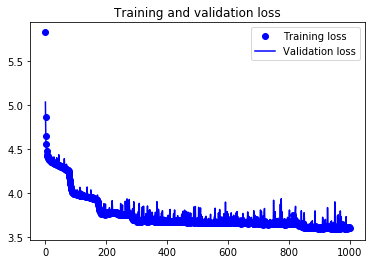

In [19]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'bo', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

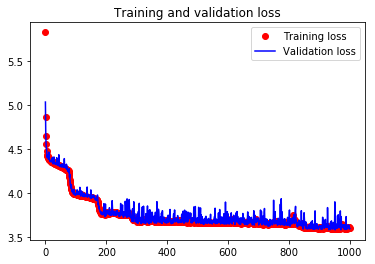

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
pred = vae.predict(x_test)

In [22]:
pred.shape

(10001, 12)

In [23]:
z_test = encoder.predict(x_test, batch_size=batch_size)

In [24]:
z_test

[array([[-0.19591421,  0.02229791],
        [ 0.10480631, -0.23339082],
        [-0.1558242 ,  0.30220413],
        ...,
        [-0.11571007,  0.31117278],
        [-0.08434568, -0.12337831],
        [-0.06669077, -0.21387453]], dtype=float32),
 array([[-0.0013771 , -0.00137711],
        [-0.00075179, -0.0007518 ],
        [ 0.00033399,  0.00033399],
        ...,
        [-0.00011674, -0.00011674],
        [-0.00191084, -0.00191084],
        [-0.00173517, -0.00173517]], dtype=float32),
 array([[-0.9935852 ,  0.11308458],
        [ 0.4096509 , -0.9122424 ],
        [-0.45828956,  0.8888029 ],
        ...,
        [-0.34853485,  0.9372958 ],
        [-0.56436   , -0.82552874],
        [-0.2976852 , -0.95466405]], dtype=float32)]

In [25]:
decoder_test=decoder.predict(z_test[0],batch_size=batch_size)

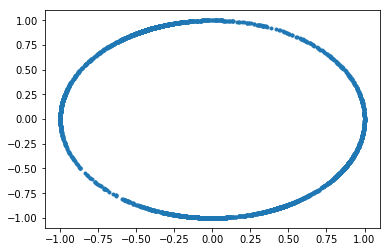

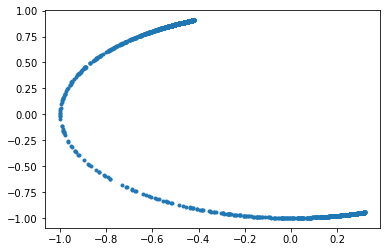

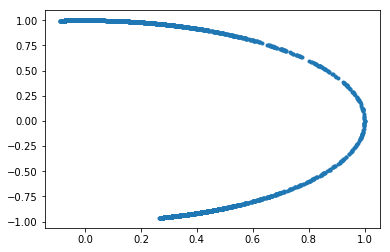

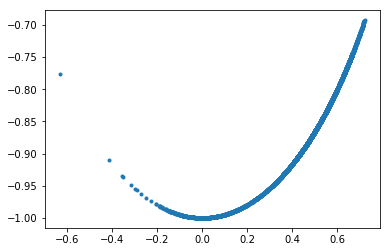

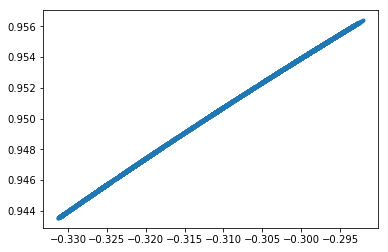

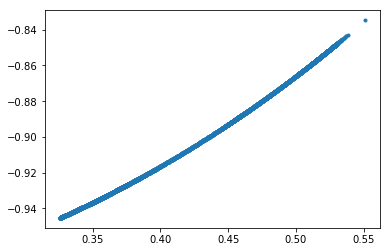

In [26]:
for i in range(6):
    plot(decoder_test[:,i*2],decoder_test[:,i*2+1],'.')
    show()

In [27]:
print(len(decoder_test))

10001


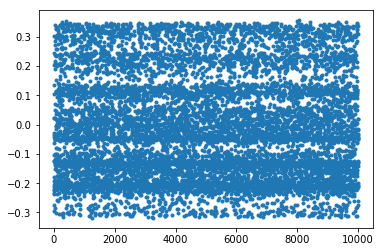

In [28]:
#plot(z_test[0][:,0],'.')
plot(z_test[0][:,1],'.')

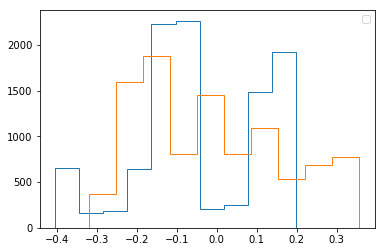

In [29]:
hist(z_test[0][:,0], histtype='step', )
hist(z_test[0][:,1], histtype='step')
legend()

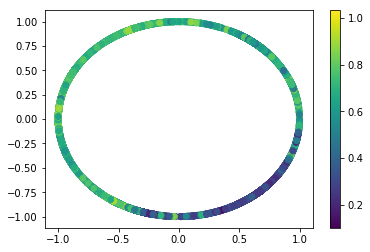

In [30]:

scatter(z_test[2][:,0],z_test[2][:,1],c=y_test)
colorbar()

In [31]:
z_train = encoder.predict(x_train, batch_size=batch_size)

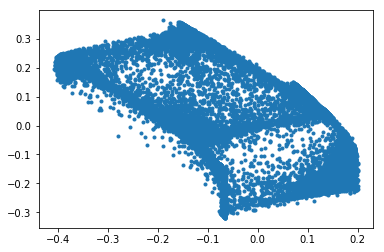

In [42]:
plot(z_train[0][:,0],z_train[0][:,1],'.')


In [43]:
weights = vae.get_weights()

In [44]:
for i in range(14): print(weights[i].shape)

(12, 8)
(8,)
(8, 4)
(4,)
(4, 2)
(2,)
(4, 2)
(2,)
(2, 4)
(4,)
(4, 8)
(8,)
(8, 2)
(2,)


In [45]:
print(weights[0])

[[ 0.20420627 -2.3246706   0.38068107 -0.6151882  -0.5263947  -0.6855546
   1.0819182   0.9134386 ]
 [-0.5108379   0.74815226 -0.09705067  0.37898672 -0.36984718  0.8572091
   0.806214   -0.05926273]
 [ 0.7478279   0.3735325  -0.9546872   0.596191   -0.04649481  0.65657634
  -0.06060835  0.79018646]
 [ 0.87439674 -0.53174525  0.7576311  -0.42869532 -0.08638638 -0.4175334
  -0.5624696  -1.3092973 ]
 [ 1.1591659   0.905863    0.79837835  2.0310109  -1.7096003  -0.502269
  -1.447628   -0.80822766]
 [ 1.7034572  -0.13547856 -0.942252   -0.9446597   1.4295053   0.9369876
  -0.85133797 -0.49345443]
 [ 0.11573121  0.25602448  0.47531423 -0.06249458  0.23053227 -0.5400601
  -0.45037416  1.1433481 ]
 [-0.15400079 -0.49064565 -1.1201633   0.6079078  -0.50745106 -0.03487735
  -0.08916087 -1.3661917 ]
 [-1.2385025  -0.13202122 -1.5508556  -0.6729566  -0.80209076 -0.3406131
   1.4737474   0.00653014]
 [ 0.23553304 -0.20010087  1.2488095   0.42772     1.0877589  -0.4891178
  -2.3030896   0.35196862]

In [46]:
first_layer_weights = weights[0]
first_layer_biases  = weights[1]
second_layer_weights = weights[2]
second_layer_biases  = weights[3]
third_layer_weights = weights[4]
third_layer_biases  = weights[5]

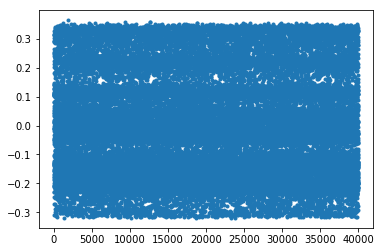

In [47]:
plot(z_train[0][:,1],'.')

In [54]:
np.savetxt('temp',weights[5].T,delimiter=',')

In [39]:
weights[1]

array([-0.49741474,  0.54176146,  2.384017  ,  0.57679886, -0.68661314,
       -0.31728175, -0.02276849, -0.6314157 ], dtype=float32)

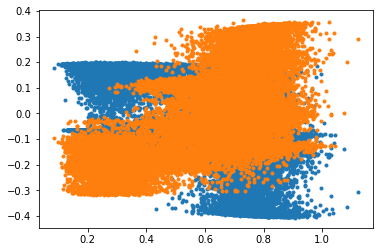

In [40]:
plot(y_train, z_train[0],'.')

In [41]:
scatter(np.arctan2(x_train[:,1]-0.11089574722092439,x_train[:,0]-0.8373638540318044),np.arctan2(x_train[:,3]
-0.6151028330760221,x_train[:,2]
+ 0.3988736246362931),c=reshape(z_train[0],(40000,)))
colorbar()

ValueError: cannot reshape array of size 80000 into shape (40000,)

In [ ]:
scatter(x_train[:,11],reshape(z_train[0],(40000,)))